# 下準備

In [14]:
# 必要なライブラリをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

**日本語を表示するための準備**

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Text(0.5, 1.0, '日本語を表示できるかテスト')

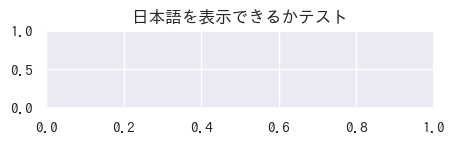

In [15]:
!apt-get update -qq
!apt-get install fonts-ipafont-gothic -qq

from matplotlib import font_manager

# インストールしたフォントのパスを取得
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'

# フォントを Matplotlib に追加
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'IPAGothic'

sns.set(font='IPAGothic')

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

**データ読込**

*「基礎的なコード集」で作成したデータセットを用います*

In [16]:
# Googleドライブをマウント
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Excelファイルを読み込み、データフレームに格納
df = pd.read_csv("/content/drive/MyDrive/カスタムデータセット/data.csv")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   能力評価      5000 non-null   float64
 1   性格診断結果    5000 non-null   int64  
 2   思索型:内閉性   5000 non-null   float64
 3   自制型:弱気さ   5000 non-null   float64
 4   従順性       5000 non-null   float64
 5   ﾓﾗﾄﾘｱﾑ傾向  5000 non-null   float64
 6   自己信頼性     5000 non-null   float64
 7   努力型:持続性   5000 non-null   float64
 8   積極性       5000 non-null   float64
 9   協調性       5000 non-null   float64
 10  共感性       5000 non-null   float64
 11  努力型:規則性   5000 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 468.9 KB


**分類問題に適用させるために、予測する値（能力評価）を数値から文字に変換します**

In [19]:
# 四捨五入
df['能力評価'] = df['能力評価'].round()

# 評価辞書の定義
evaluation_dict = {
    'S': 5.0,
    'A': 4.0,
    'B': 3.0,
    'C': 2.0,
    'D': 1.0,
    '－': 0
}

# 評価辞書を逆にする
reverse_dict = {v: k for k, v in evaluation_dict.items()}

# 数値からアルファベットに変換
df['能力評価'] = df['能力評価'].map(reverse_dict)

In [20]:
df.head(10)

,能力評価,性格診断結果,思索型:内閉性,自制型:弱気さ,従順性,ﾓﾗﾄﾘｱﾑ傾向,自己信頼性,努力型:持続性,積極性,協調性,共感性,努力型:規則性
0,B,4,49.7355,54.83225,50.00000,30.0000,54.000,51.00000,52.00000,44.8645,52.0000,55.0000
1,B,0,48.0000,38.00000,55.00000,41.0000,34.000,40.00000,63.00000,53.0000,26.0000,53.8765
2,B,4,49.7355,54.83225,45.00000,51.0000,39.000,39.53575,61.00000,74.0000,57.0000,62.0000
3,B,6,64.0000,54.83225,32.00000,54.0000,36.000,69.00000,48.00000,44.0000,31.5885,46.0000
4,B,0,72.0000,62.00000,42.00000,43.7975,42.000,21.00000,50.13425,61.0000,21.0000,53.8765
5,B,2,50.0000,62.00000,24.00000,53.0000,38.418,51.00000,74.00000,71.0000,59.0000,51.0000
6,A,1,44.0000,37.00000,44.02225,44.0000,38.418,39.53575,65.00000,41.0000,20.0000,44.0000
7,A,6,49.0000,74.00000,44.02225,33.0000,38.000,59.00000,50.13425,47.0000,31.5885,35.0000
8,B,0,49.7355,54.83225,53.00000,42.0000,33.000,54.00000,38.00000,14.0000,31.5885,61.0000
9,B,5,49.7355,54.83225,39.00000,54.0000,38.418,50.00000,57.00000,44.8645,12.0000,53.8765


In [21]:
df["能力評価"].unique()

array(['B', 'A', 'C'], dtype=object)

# 決定木モデルの作成（分類モデル）

In [22]:
# 必要なライブラリをインストール
!pip install graphviz
!pip install pydotplus
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.7 MB/s eta 0:00:00


In [23]:
# 必要なライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

import pydotplus

In [24]:
# 特徴量とターゲットに分ける
X = df.drop('能力評価', axis=1)
y = df['能力評価']

# トレーニングセットとテストセットに分割
# 訓練用データを元データの8割、テスト評価用のデータを元データの2割に設定して分割します。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

**設計者が決めるパラメータの最適解を求めるために、「ハイパーパラメータ探索」を行う**

ハイパーパラメータ探索には「グリッドサーチ」「ランダムサーチ」「ベイズ最適化」などの方法が挙げられますが、今回は全ての範囲をしらみつぶしで探索する「グリッドサーチ」を用います

In [25]:
from sklearn.model_selection import GridSearchCV


# パラメータグリッドの設定（範囲拡大）
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 4, 5, 6],  # 深さの範囲を拡大
    'min_samples_split': [2, 4, 6, 8, 10, 12],  # 最小分割サンプル数を増加
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],  # 最小葉サンプル数の範囲を拡大
    'max_features': [None, 'sqrt', 'log2'],  # 'auto' を削除
    'class_weight': [None, 'balanced', {'A': 1, 'B': 2, 'C': 1}],  # クラスラベルに合わせて修正
    'min_impurity_decrease': [0.0, 0.01, 0.03],  # ノード分割の最小不純度減少
}

# モデルのインスタンス化
model = DecisionTreeClassifier()

# グリッドサーチの設定
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 38880 candidates, totalling 194400 fits
Best parameters found:  {'class_weight': {'A': 1, 'B': 2, 'C': 1}, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Best score:  0.67275


**最適なパラメーターがわかったので、これを用いて決定木モデルを構築します**

In [26]:
# 最適なパラメータでモデルの作成
#best_model = grid_search.best_estimator_

# 手動で最適なパラメータを設定
best_model = DecisionTreeClassifier(
    class_weight=None,
    criterion='gini',
    max_depth=5,
    max_features='sqrt',
    min_impurity_decrease=0.0,
    min_samples_leaf=6,
    min_samples_split=12,
    splitter='random'
)


# トレーニングデータに対するモデルの適合
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=12, splitter='random')

**構築したモデルと先ほど分割したテスト評価用データを用いて、モデルの評価を行います**

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 予測
y_pred = best_model.predict(X_test)

# 評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.687
Precision: 0.47545636910732203
Recall: 0.687
F1 Score: 0.5619798458802607


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**構築した決定木を可視化します**

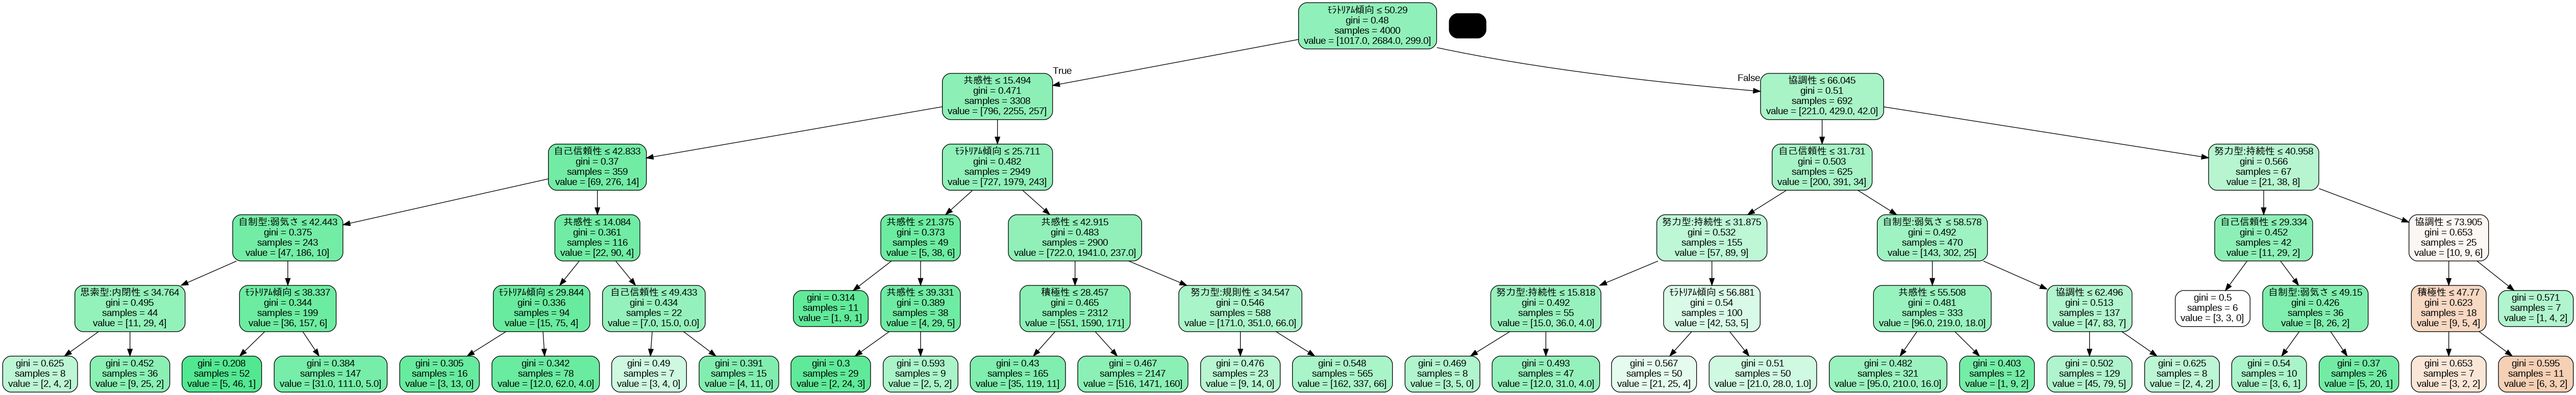

In [28]:
# 決定木をエクスポート
dot_data = export_graphviz(
    best_model,  # グリッドサーチ後の最適なモデルを使用
    out_file=None,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    special_characters=True
)

# グラフを生成
graph = pydotplus.graph_from_dot_data(dot_data)

# グラフを表示
Image(graph.create_png())

In [29]:
# 学習済みのモデルからクラスの順番を取得
class_labels = best_model.classes_

# クラスの順番を表示
print("Class order:", class_labels)

Class order: ['A' 'B' 'C']


**分類問題では混同行列を用いることで構築したモデルを解釈できます**

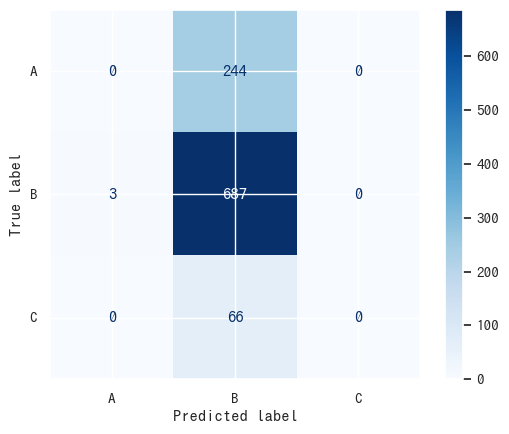

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 混同行列の計算
cm = confusion_matrix(y_test, y_pred)

# ラベルを明示的に指定
labels = sorted(set(y_test))  # テストデータのラベルを元にクラスラベルを取得

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

# 表示
import matplotlib.pyplot as plt
plt.show()

**構築した機械学習モデルを保存します**

**これにより、他のプログラムでこの機械学習モデルを用いることができます。**

In [ ]:
import joblib

# 決定木をエクスポート
joblib.dump(best_model, 'best_model.pkl')


# 保存したモデルを読み込む
# loaded_tree = joblib.load('best_decision_tree_model.pkl')

"\n# モデルをインポート\nimport joblib\n\n# 保存したモデルを読み込む\nloaded_tree = joblib.load('best_decision_tree_model.pkl')\n"